# Linear mixed effects model benchmark

In [2]:
import pandas as pd
import polars as pl
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, KFold
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import expit
from pymer4.models import Lmer
from itertools import product
import time
from datetime import timedelta

In [3]:
# Load black for formatting
import jupyter_black

jupyter_black.load()
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

In [4]:
sns.set_style("ticks")
plt.rc("figure", titlesize="medium")
plt.rc("font", size=10, family="serif")
plt.rc("axes", titlesize="medium")
plt.rc("text", usetex=True)
plt.rc("text.latex", preamble=r"\usepackage{amsmath}\usepackage{amssymb}")

In [5]:
import warnings

warnings.filterwarnings("ignore", message="DataFrame.applymap has been deprecated")

## Read data and select variables

In [6]:
df = pl.read_parquet("../../data/runs/run_folder_2024-05-20_17.56/model_data.parquet")
df.head()

SS,SSB,SSBS,Biome,Realm,Ecoregion,Biome_Realm,Biome_Realm_Ecoregion,Longitude,Latitude,Max_scaled_abundance,Primary vegetation_Light use,Primary vegetation_Intense use,Secondary vegetation_Minimal use,Secondary vegetation_Light use,Secondary vegetation_Intense use,Cropland_Minimal use,Cropland_Light_Intense,Pasture_Minimal use,Pasture_Light_Intense,Urban_All uses,Pop_density_1km_log,Road_density_50km_cbrt,Mean_pop_density_1km_log,Primary vegetation_Light use x Pop_density_1km_log,Primary vegetation_Intense use x Pop_density_1km_log,Secondary vegetation_Minimal use x Pop_density_1km_log,Secondary vegetation_Light use x Pop_density_1km_log,Secondary vegetation_Intense use x Pop_density_1km_log,Cropland_Minimal use x Pop_density_1km_log,Cropland_Light_Intense x Pop_density_1km_log,Pasture_Minimal use x Pop_density_1km_log,Pasture_Light_Intense x Pop_density_1km_log,Urban_All uses x Pop_density_1km_log,Primary vegetation_Light use x Road_density_50km_cbrt,Primary vegetation_Intense use x Road_density_50km_cbrt,Secondary vegetation_Minimal use x Road_density_50km_cbrt,Secondary vegetation_Light use x Road_density_50km_cbrt,Secondary vegetation_Intense use x Road_density_50km_cbrt,Cropland_Minimal use x Road_density_50km_cbrt,Cropland_Light_Intense x Road_density_50km_cbrt,Pasture_Minimal use x Road_density_50km_cbrt,Pasture_Light_Intense x Road_density_50km_cbrt,Urban_All uses x Road_density_50km_cbrt
str,str,str,str,str,str,str,str,f64,f64,f64,u8,u8,u8,u8,u8,u8,i32,u8,i32,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""AD1_2001__Liow…","""AD1_2001__Liow…","""AD1_2001__Liow…","""Tropical & Sub…","""Indo-Malay""","""Peninsular Mal…","""Tropical & Sub…","""Tropical & Sub…",103.533333,2.066667,1.0,0,0,0,0,0,0,0,0,0,0,0.139242,0.329559,-0.52466,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""AD1_2009__Verg…","""AD1_2009__Verg…","""AD1_2009__Verg…","""Tropical & Sub…","""Neotropic""","""Veracruz Moist…","""Tropical & Sub…","""Tropical & Sub…",-96.89967,19.211,0.843023,0,0,0,1,0,0,0,0,0,0,0.521121,-0.262933,0.965439,0.0,0.0,0.0,0.521121,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.262933,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
"""AD1_2009__Verg…","""AD1_2009__Verg…","""AD1_2009__Verg…","""Tropical & Sub…","""Neotropic""","""Veracruz Moist…","""Tropical & Sub…","""Tropical & Sub…",-96.9255,19.47267,0.918605,0,0,0,1,0,0,0,0,0,0,1.267749,-0.413602,0.965439,0.0,0.0,0.0,1.267749,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.413602,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
"""AD1_2009__Verg…","""AD1_2009__Verg…","""AD1_2009__Verg…","""Tropical & Sub…","""Neotropic""","""Veracruz Moist…","""Tropical & Sub…","""Tropical & Sub…",-96.92917,19.4715,0.930233,0,0,0,1,0,0,0,0,0,0,1.18345,-0.412494,0.965439,0.0,0.0,0.0,1.18345,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.412494,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
"""AD1_2013__Gras…","""AD1_2013__Gras…","""AD1_2013__Gras…","""Tropical & Sub…","""Afrotropic""","""Kwazulu-Cape C…","""Tropical & Sub…","""Tropical & Sub…",30.26825,-30.69594,0.047361,1,0,0,0,0,0,0,0,0,0,-1.31719,0.174812,-0.986835,-1.31719,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.174812,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
df.shape

(7591, 44)

In [8]:
def transform_response_variable(df: pl.DataFrame, method: str) -> pl.DataFrame:

    adjust = 0.001
    original_col_name = "Max_scaled_abundance"
    transformed_col_name = original_col_name

    # Small adjustment to align with support for Beta distribution
    if method == "adjust" or method == "logit":
        df = df.with_columns(
            pl.when(pl.col(original_col_name) == 0)
            .then(adjust)
            .when(pl.col(original_col_name) == 1)
            .then(1 - adjust)
            .otherwise(pl.col(original_col_name))
            .alias(original_col_name)
        )
        if method == "logit":
            transformed_col_name += "_logit"
            df = df.with_columns(
                pl.col(original_col_name)
                .map_elements(lambda x: logit(x))
                .alias(transformed_col_name)
            )

    # Square root transformation
    elif method == "sqrt":
        transformed_col_name += "_sqrt"
        df = df.with_columns(
            pl.col(original_col_name).sqrt().alias(transformed_col_name)
        )

    # Replace original column with transformed one, if the name has changed
    if transformed_col_name != original_col_name:
        original_col_index = df.columns.index(original_col_name)
        new_col = df.get_column(transformed_col_name)
        df = df.drop([original_col_name, transformed_col_name])
        df = df.insert_column(index=original_col_index, column=new_col)

    return df

In [9]:
df = transform_response_variable(df, "sqrt")

In [10]:
df = df.to_pandas()

# R doesn't like blanks in column headers
df.columns = df.columns.str.replace(" ", "_")

response = "Max_scaled_abundance_sqrt"
groups = ["SS", "SSB", "SSBS"]

# Create list of all covariates to be used
fe_vars = [
    col
    for col in df.columns
    if col
    not in [
        "Intercept",
        "SS",
        "SSB",
        "SSBS",
        "Biome",
        "Realm",
        "Ecoregion",
        "Biome_Realm",
        "Biome_Realm_Ecoregion",
        "Max_scaled_abundance_sqrt",
        "Latitude",
        "Longitude",
    ]
]

re_vars = [
    "Primary_vegetation_Light_use",
    "Primary_vegetation_Intense_use",
    "Secondary_vegetation_Minimal_use",
    "Secondary_vegetation_Light_use",
    "Secondary_vegetation_Intense_use",
    "Cropland_Minimal_use",
    "Cropland_Light_Intense",
    "Pasture_Minimal_use",
    "Pasture_Light_Intense",
    "Urban_All_uses",
]

## Model training and prediction

In [18]:
def fit_lme_model(
    df,
    response,
    fe_vars,
    study_int=True,
    block_int=False,
    study_vars=None,
    block_vars=None,
    independent_re=False,
):
    fe_formula = " + ".join(fe_vars)
    formula = f"{response} ~ {fe_formula}"

    # Handling study-level random effects
    if study_vars:
        if independent_re:
            # Independent random effects for each variable in study_vars
            re_study_formula = "(1|SS) + "
            re_study_formula += " + ".join(f"({var}-1|SS)" for var in study_vars)
        else:
            # Correlated random effects, combining study_vars
            re_study_vars = " + ".join(study_vars)
            re_study_formula = f"({re_study_vars}|SS)"
        formula += f" + {re_study_formula}"

    elif study_int:
        # Random intercept for study only
        formula += " + (1|SS)"

    # Handling block-level random effects
    if block_vars:
        if independent_re:
            re_block_formula = "(1|SS:SSB) + "
            # Independent random effects for each variable in block_vars
            re_block_formula += " + ".join(f"({var}-1|SS:SSB)" for var in block_vars)
        else:
            # Correlated random effects, combining block_vars
            re_block_vars = " + ".join(block_vars)
            re_block_formula = f"({re_block_vars}|SS:SSB)"
        formula += f" + {re_block_formula}"

    elif block_int:
        # Random intercept for block only
        formula += " + (1|SS:SSB)"

    model = Lmer(formula, data=df)
    model.fit(conf_int="boot", nsim=100, summary=False, REML=True)

    return model

In [19]:
start = time.time()
model = fit_lme_model(
    df,
    response=response,
    fe_vars=fe_vars,
    study_int=True,
    block_int=True,
    study_vars=re_vars,
    block_vars=None,
    independent_re=False,
)
runtime = str(timedelta(seconds=int(time.time() - start)))
print(runtime)

boundary (singular) fit: see help('isSingular') 

1 day, 17:24:43


In [10]:
print(model.summary())

Linear mixed model fit by REML [’lmerMod’]
Formula: Max_scaled_abundance_sqrt~Primary_vegetation_Light_use+Primary_vegetation_Intense_use+Secondary_vegetation_Minimal_use+Secondary_vegetation_Light_use+Secondary_vegetation_Intense_use+Cropland_Minimal_use+Cropland_Light_Intense+Pasture_Minimal_use+Pasture_Light_Intense+Urban_All_uses+Pop_density_1km_log+Road_density_50km_cbrt+Mean_pop_density_1km_log+Primary_vegetation_Light_use_x_Pop_density_1km_log+Primary_vegetation_Intense_use_x_Pop_density_1km_log+Secondary_vegetation_Minimal_use_x_Pop_density_1km_log+Secondary_vegetation_Light_use_x_Pop_density_1km_log+Secondary_vegetation_Intense_use_x_Pop_density_1km_log+Cropland_Minimal_use_x_Pop_density_1km_log+Cropland_Light_Intense_x_Pop_density_1km_log+Pasture_Minimal_use_x_Pop_density_1km_log+Pasture_Light_Intense_x_Pop_density_1km_log+Urban_All_uses_x_Pop_density_1km_log+Primary_vegetation_Light_use_x_Road_density_50km_cbrt+Primary_vegetation_Intense_use_x_Road_density_50km_cbrt+Secondar

In [13]:
# Make predictions with and without random effects
pred_only_fe = model.predict(
    df, use_rfx=False, skip_data_checks=True, verify_predictions=False
)
pred_with_re = model.predict(
    df, use_rfx=True, skip_data_checks=True, verify_predictions=False
)
# Get the true values
y_true = df["Max_scaled_abundance_sqrt"]

In [12]:
def calculate_marginal_and_conditional_r2(y_true, pred_fe, pred):

    marg_r2 = np.var(pred_fe) / (np.var(pred) + np.var(y_true - pred))
    cond_r2 = np.var(pred) / (np.var(pred) + np.var(y_true - pred))

    return marg_r2, cond_r2

In [14]:
def inverse_transform_response(y: np.array, method: str) -> np.array:
    """Add docstring."""
    if method == "logit":
        res = expit(y)
    elif method == "sqrt":
        res = np.square(y)
    else:
        res = y

    return res

In [40]:
marg_r2, cond_r2 = calculate_marginal_and_conditional_r2(
    y_true, pred_only_fe, pred_with_re
)
print("Model fit, no back-transformation:\n")
print(f"Marginal R2: {marg_r2:.3f}")
print(f"Conditional R2: {cond_r2:.3f}")

Model fit, no back-transformation:

Marginal R2: 0.053
Conditional R2: 0.626


In [15]:
# Rescale true and predicted values to original scale

transform = "sqrt"

y_true_trans = inverse_transform_response(y_true, transform)
pred_only_fe_trans = inverse_transform_response(pred_only_fe, transform)
pred_with_re_trans = inverse_transform_response(pred_with_re, transform)

In [42]:
marg_r2, cond_r2 = calculate_marginal_and_conditional_r2(
    y_true_trans, pred_only_fe_trans, pred_with_re_trans
)
print("Model fit, including back-transformation:\n")
print(f"Marginal R2: {marg_r2:.3f}")
print(f"Conditional R2: {cond_r2:.3f}")

Model fit, including back-transformation:

Marginal R2: 0.071
Conditional R2: 0.590


## Plot outputs: Actual and predictions are not back-transformed

In [16]:
def plot_predictions_and_residuals(y_true: np.array, y_pred: np.array) -> None:
    """
    Plots various visualizations to analyze regression model results.
    - The first plot is a scatter plot of predictions and actuals.
    - Second plot shows all residual values.
    - Third plot shows residuals as a density graph.
    """

    colors = plt.cm.viridis(np.array([0, 0.5, 0.95]))

    # Scatter plot of predictions vs actuals
    fig = plt.figure(figsize=(4.5, 2.8))
    plt.scatter(y_true, y_pred, alpha=0.2, s=5, color=colors[0])
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], "--k", linewidth=1)
    plt.xlabel("Observed values")
    plt.ylabel("Predicted values")
    sns.despine()
    plt.tight_layout()
    plt.show()

    # Residuals vs actual scatter plot
    residuals = y_true - y_pred
    plt.figure(figsize=(6, 4))
    plt.scatter(y_true, residuals, alpha=0.2)
    plt.axhline(y=0, color="r", linestyle="--", linewidth=2)
    plt.xlabel("Actual values")
    plt.ylabel("Residuals")
    plt.title("Residuals vs actual values")
    plt.grid(True)
    plt.show()

    # Residual Density Plot (Distribution of Residuals)
    plt.figure(figsize=(6, 4))
    sns.kdeplot(residuals, fill=True)
    plt.xlabel("Residuals")
    plt.ylabel("Density")
    plt.title("Residual density Plot")
    plt.grid(True)
    plt.show()

    return fig

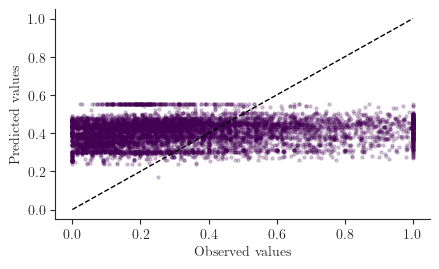

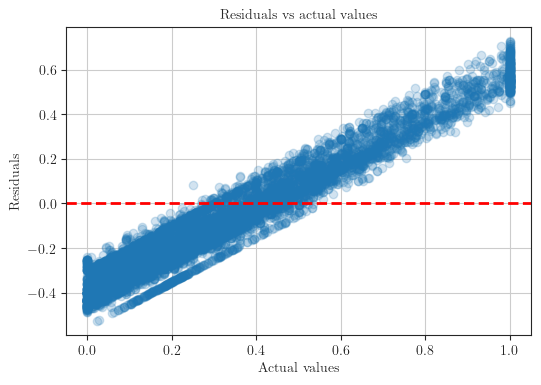

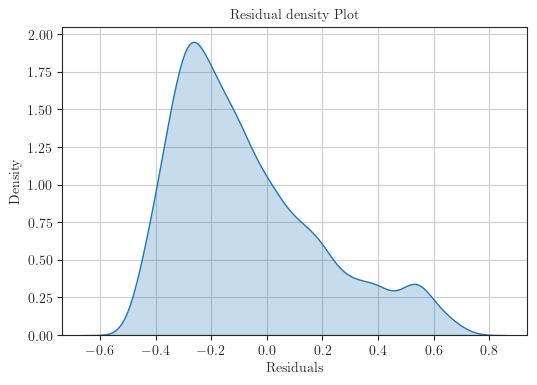

In [17]:
# Plot with predictions including RE
fig = plot_predictions_and_residuals(y_true_trans, pred_only_fe_trans)
fig.savefig("../../figures/bii_pred_color.pdf")

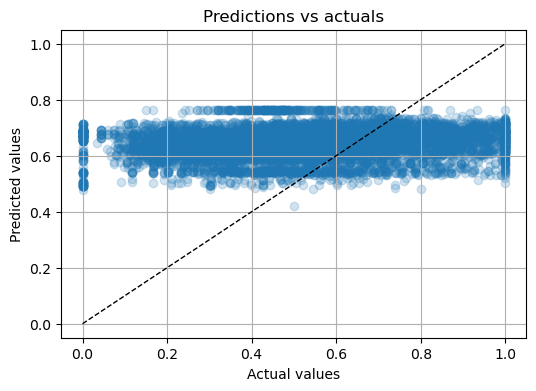

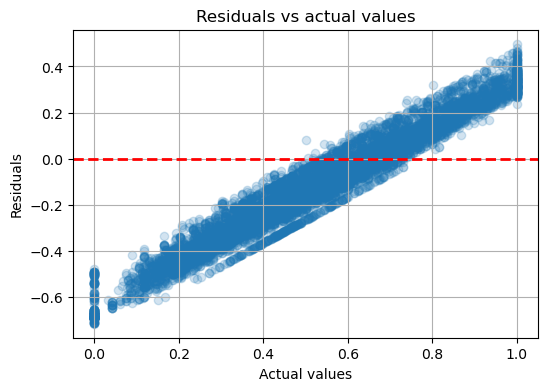

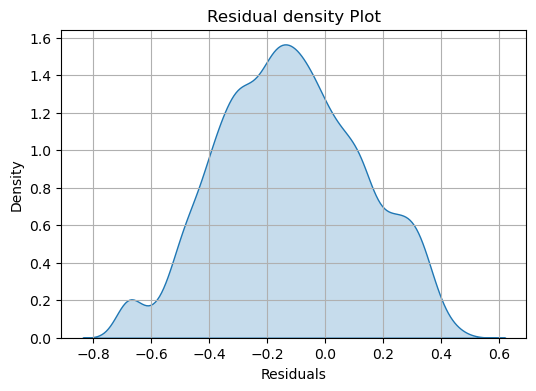

In [46]:
# Plot with predictions excluding RE
plot_predictions_and_residuals(y_true, pred_only_fe)

In [ ]:
model.plot_summary();

## Plot outputs: Back-transforming to original 0-1 scale

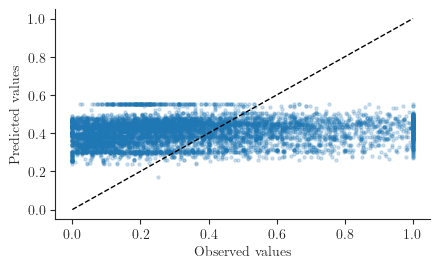

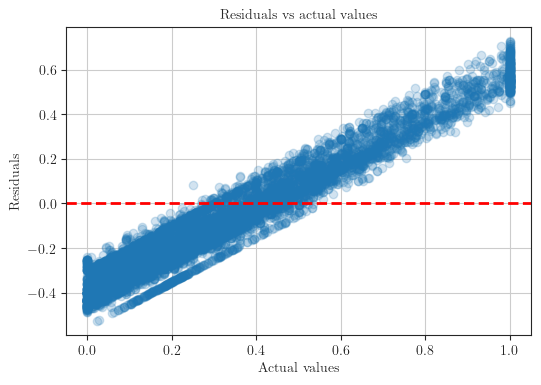

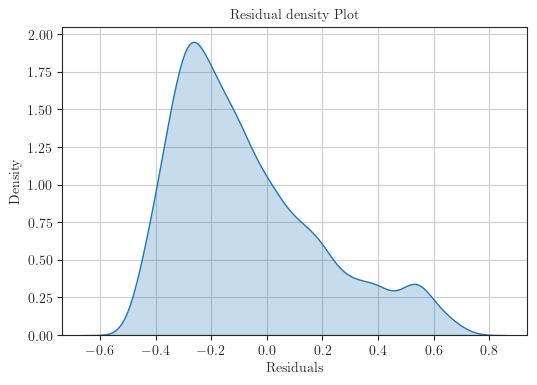

In [59]:
# Plot with predictions including RE
fig = plot_predictions_and_residuals(y_true_trans, pred_only_fe_trans)
fig.savefig("../../figures/bii_predictions.pdf")

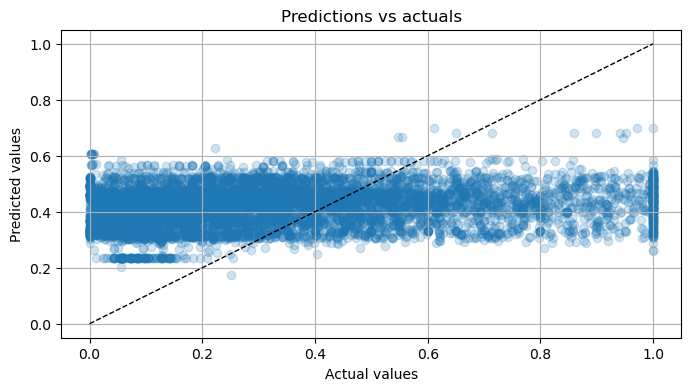

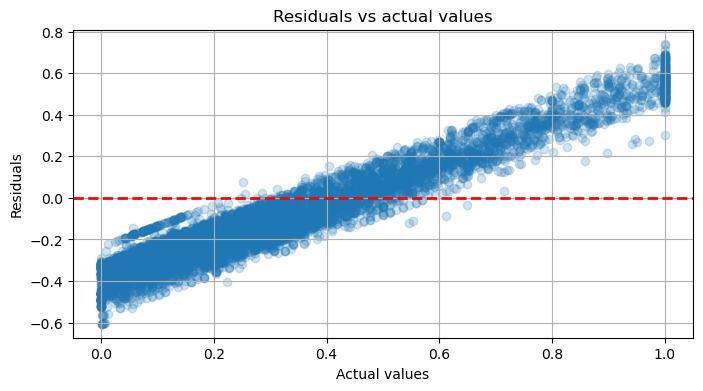

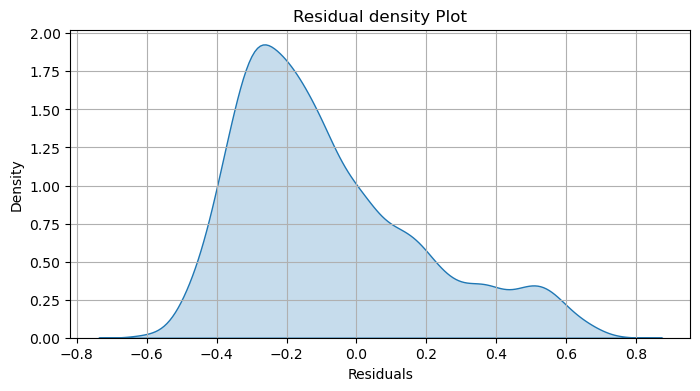

In [60]:
# Plot with predictions excluding RE
plot_predictions_and_residuals(y_true_trans, pred_only_fe_trans)

## Cross-validation

In [13]:
def create_stratification_column(
    df: pd.DataFrame, stratify_groups: list[str]
) -> pd.DataFrame:
    """
    Create a new column for stratification by concatenating the
    specified group columns.
    """

    if len(stratify_groups) > 1:
        df["Stratify_group"] = df[stratify_groups].astype(str).agg("_".join, axis=1)
    else:
        df["Stratify_group"] = df[stratify_groups[0]]

    return df

In [14]:
def generate_kfolds(
    df: pd.DataFrame,
    y_var: str,
    x_vars: list[str],
    groups: list[str],
    k: int = 5,
    stratify: bool = False,
) -> tuple[list[pd.DataFrame], list[pd.DataFrame], list[pd.Series], list[pd.Series]]:

    # Lists for storing the train and test datasets
    x_train_list = []
    x_test_list = []
    y_train_list = []
    y_test_list = []
    group_train_list = []
    group_test_list = []

    # Set up stratified k-fold sampler object and sample using the
    # stratify code (as the "y class label") for stratification
    if stratify:
        kfold = StratifiedKFold(n_splits=k, shuffle=True)
        strat_col = df["Stratify_group"]
    else:
        kfold = KFold(n_splits=k, shuffle=True)
        strat_col = None

    for train_index, test_index in kfold.split(X=df, y=strat_col):
        x_train, x_test = df.iloc[train_index][x_vars], df.iloc[test_index][x_vars]
        y_train, y_test = df.iloc[train_index][y_var], df.iloc[test_index][y_var]
        group_train, group_test = (
            df.iloc[train_index][groups],
            df.iloc[test_index][groups],
        )

        # Store the data for this fold
        x_train_list.append(x_train)
        x_test_list.append(x_test)
        y_train_list.append(y_train)
        y_test_list.append(y_test)
        group_train_list.append(group_train)
        group_test_list.append(group_test)

    return (
        x_train_list,
        x_test_list,
        y_train_list,
        y_test_list,
        group_train_list,
        group_test_list,
    )

In [37]:
# Stratify the data on study
df = create_stratification_column(df, ["SS"])

In [38]:
# Generate folds
(
    x_train_list,
    x_test_list,
    y_train_list,
    y_test_list,
    group_train_list,
    group_test_list,
) = generate_kfolds(
    df,
    y_var=response,
    x_vars=fe_vars,
    groups=groups,
    k=5,
    stratify=True,
)

/Users/jakobnystrom/anaconda3/envs/biodiv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [35]:
def run_lme_cross_validation(
    df,
    response: str,
    fe_vars: list[str],
    re_vars: list[str],
    x_train_list,
    x_test_list,
    y_train_list,
    y_test_list,
    group_train_list,
    group_test_list,
    transform_type,
):

    test_mean_abs_err_list = []
    train_mean_abs_err_list = []
    test_median_abs_err_list = []
    train_median_abs_err_list = []
    df_output_test = pd.DataFrame()

    for i in range(len(x_train_list)):
        # Get the train and test data
        x_train, x_test = x_train_list[i], x_test_list[i]
        y_train, y_test = y_train_list[i], y_test_list[i]
        group_train, group_test = group_train_list[i], group_test_list[i]

        # Merge in order to fit structure of Pymer4 LME model, and fit the model
        df_train = pd.concat([group_train, y_train, x_train], axis="columns")
        df_test = pd.concat([group_test, y_test, x_test], axis="columns")
        model = fit_lme_model(
            df_train,
            response=response,
            fe_vars=fe_vars,
            study_int=True,
            block_int=True,
            study_vars=re_vars,
            block_vars=None,
            independent_re=False,
        )

        # Make predictions on the training set
        pred_train = model.predict(
            df_train, use_rfx=False, skip_data_checks=True, verify_predictions=False
        )

        # Make predictions on the test set
        pred_test = model.predict(
            df_test, use_rfx=False, skip_data_checks=True, verify_predictions=False
        )

        # Back-transform values to original 0-1 scale
        y_train = inverse_transform_response(y_train, transform_type)
        pred_train = inverse_transform_response(pred_train, transform_type)
        y_test = inverse_transform_response(y_test, transform_type)
        pred_test = inverse_transform_response(pred_test, transform_type)

        # Save predictions and final outputs
        df_test["Pred"] = pred_test
        ref_pred = inverse_transform_response(model.coefs.iloc[0, 0], transform_type)
        df_test["Pred_final"] = pred_test / ref_pred

        # Add this fold to the final dataframe
        df_output_test = pd.concat([df_output_test, df_test], axis="rows")

        # Compute accuracy metrics and evaluate
        mean_abs_err_test = mean_absolute_error(y_test, pred_test)
        mean_abs_err_train = mean_absolute_error(y_train, pred_train)
        median_abs_err_test = median_absolute_error(y_test, pred_test)
        median_abs_err_train = median_absolute_error(y_train, pred_train)

        test_mean_abs_err_list.append(mean_abs_err_test)
        train_mean_abs_err_list.append(mean_abs_err_train)
        test_median_abs_err_list.append(median_abs_err_test)
        train_median_abs_err_list.append(median_abs_err_train)

    return (
        test_mean_abs_err_list,
        train_mean_abs_err_list,
        test_median_abs_err_list,
        train_median_abs_err_list,
        df_output_test,
    )

In [41]:
def print_crossval_results(
    test_mean_abs_err_list,
    train_mean_abs_err_list,
    test_median_abs_err_list,
    train_median_abs_err_list,
):
    print("Cross-validation results \n")
    print(
        f"Mean abs error, test: {np.mean(test_mean_abs_err_list):.3f} (mean) | {np.std(test_mean_abs_err_list):.3f} (std)"
    )
    print(
        f"Mean abs error, train: {np.mean(train_mean_abs_err_list):.3f} (mean) | {np.std(train_mean_abs_err_list):.3f} (std)"
    )
    print("\n")
    print(
        f"Median abs error, test: {np.mean(test_median_abs_err_list):.3f} (mean) | {np.std(test_median_abs_err_list):.3f} (std)"
    )
    print(
        f"Median abs error, train: {np.mean(train_median_abs_err_list):.3f} (mean) | {np.std(train_median_abs_err_list):.3f} (std)"
    )

In [39]:
# Run the cross validation and print results
(
    test_mean_abs_err_list,
    train_mean_abs_err_list,
    test_median_abs_err_list,
    train_median_abs_err_list,
    df_output_test,
) = run_lme_cross_validation(
    df,
    response,
    fe_vars,
    re_vars,
    x_train_list,
    x_test_list,
    y_train_list,
    y_test_list,
    group_train_list,
    group_test_list,
    transform_type="sqrt",
)

boundary (singular) fit: see help('isSingular') 

boundary (singular) fit: see help('isSingular') 

boundary (singular) fit: see help('isSingular') 

boundary (singular) fit: see help('isSingular') 

boundary (singular) fit: see help('isSingular') 



In [42]:
print_crossval_results(
    test_mean_abs_err_list,
    train_mean_abs_err_list,
    test_median_abs_err_list,
    train_median_abs_err_list,
)

Cross-validation results 

Mean abs error, test: 0.232 (mean) | 0.001 (std)
Mean abs error, train: 0.232 (mean) | 0.002 (std)


Median abs error, test: 0.220 (mean) | 0.003 (std)
Median abs error, train: 0.220 (mean) | 0.002 (std)


In [43]:
df_output_test

,SS,SSB,SSBS,Max_scaled_abundance_sqrt,Longitude,Latitude,Primary_vegetation_Light_use,Primary_vegetation_Intense_use,Secondary_vegetation_Minimal_use,Secondary_vegetation_Light_use,Secondary_vegetation_Intense_use,Cropland_Minimal_use,Cropland_Light_Intense,Pasture_Minimal_use,Pasture_Light_Intense,Urban_All_uses,Pop_density_1km_log,Road_density_50km_cbrt,Mean_pop_density_1km_log,Primary_vegetation_Light_use_x_Pop_density_1km_log,Primary_vegetation_Intense_use_x_Pop_density_1km_log,Secondary_vegetation_Minimal_use_x_Pop_density_1km_log,Secondary_vegetation_Light_use_x_Pop_density_1km_log,Secondary_vegetation_Intense_use_x_Pop_density_1km_log,Cropland_Minimal_use_x_Pop_density_1km_log,Cropland_Light_Intense_x_Pop_density_1km_log,Pasture_Minimal_use_x_Pop_density_1km_log,Pasture_Light_Intense_x_Pop_density_1km_log,Urban_All_uses_x_Pop_density_1km_log,Primary_vegetation_Light_use_x_Road_density_50km_cbrt,Primary_vegetation_Intense_use_x_Road_density_50km_cbrt,Secondary_vegetation_Minimal_use_x_Road_density_50km_cbrt,Secondary_vegetation_Light_use_x_Road_density_50km_cbrt,Secondary_vegetation_Intense_use_x_Road_density_50km_cbrt,Cropland_Minimal_use_x_Road_density_50km_cbrt,Cropland_Light_Intense_x_Road_density_50km_cbrt,Pasture_Minimal_use_x_Road_density_50km_cbrt,Pasture_Light_Intense_x_Road_density_50km_cbrt,Urban_All_uses_x_Road_density_50km_cbrt,Pred,Pred_final
7,AR1_2008__Basset 1,AR1_2008__Basset 1,AR1_2008__Basset 1 7,0.550942,9.997314,-2.714905,0,0,1,0,0,0,0,0,0,0,-1.762485,-0.234643,-1.895648,-0.0,-0.000000,-1.762485,-0.0,-0.000000,-0.0,-0.0,-0.0,-0.000000,-0.0,-0.0,-0.000000,-0.234643,-0.0,-0.000000,-0.0,-0.0,-0.0,-0.000000,-0.0,0.507415,1.167074
10,AR1_2008__Navarrete 1,AR1_2008__Navarrete 1,AR1_2008__Navarrete 1 21,0.593751,-90.934900,16.138600,0,0,0,0,0,0,0,0,0,0,-2.222161,-1.124244,-1.646985,-0.0,-0.000000,-0.000000,-0.0,-0.000000,-0.0,-0.0,-0.0,-0.000000,-0.0,-0.0,-0.000000,-0.000000,-0.0,-0.000000,-0.0,-0.0,-0.0,-0.000000,-0.0,0.483265,1.111526
13,AR1_2010__Kone 1,AR1_2010__Kone 1,AR1_2010__Kone 1 4,0.927655,-5.035199,6.226813,0,0,0,0,0,0,0,0,0,0,0.022688,1.503847,-0.018148,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.435071,1.000680
21,BS1_2010__Page 1,BS1_2010__Page 1,BS1_2010__Page 1 61,0.670368,75.777440,12.285670,0,0,0,0,0,0,0,0,0,0,0.509653,1.442552,0.604377,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.435323,1.001260
30,CM1_2008__LoManHung 1,CM1_2008__LoManHung 1,CM1_2008__LoManHung 1 10,0.730297,-52.635819,-0.702434,0,0,1,0,0,0,0,0,0,0,-2.065493,-2.553937,-2.188093,-0.0,-0.000000,-2.065493,-0.0,-0.000000,-0.0,-0.0,-0.0,-0.000000,-0.0,-0.0,-0.000000,-2.553937,-0.0,-0.000000,-0.0,-0.0,-0.0,-0.000000,-0.0,0.492652,1.133118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7565,YY1_2016__Mohandass 1,YY1_2016__Mohandass 1,YY1_2016__Mohandass 1 3,0.239143,76.356570,11.143670,0,0,0,0,0,0,0,0,1,0,1.232802,1.051134,1.325248,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,1.232802,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,1.051134,0.0,0.371391,0.850308
7574,YY1_2016__Sunil 1,YY1_2016__Sunil 1,YY1_2016__Sunil 1 19,0.370681,76.748889,12.214444,0,1,0,0,0,0,0,0,0,0,2.016476,0.645216,0.981261,0.0,2.016476,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.645216,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.423464,0.969530
7578,YY1_2016__Sunil 1,YY1_2016__Sunil 1,YY1_2016__Sunil 1 6,0.676768,77.326944,12.305556,0,0,0,0,0,0,0,0,0,0,0.807598,0.670532,0.981261,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.435416,0.996895
7579,YY1_2016__Sunil 1,YY1_2016__Sunil 1,YY1_2016__Sunil 1 62,0.653820,75.862500,12.303333,0,1,0,0,0,0,0,0,0,0,0.689850,1.400524,0.981261,0.0,0.689850

In [44]:
df_output_test.to_parquet("../../data/output/model_comp/bii.parquet")

### Top / bottom quartiles

In [47]:
y_true_test = np.concatenate(y_true_test).ravel()
y_pred_test = np.concatenate(y_pred_test).ravel()

In [48]:
q1 = np.percentile(y_true_test, 25)
q3 = np.percentile(y_true_test, 75)
bottom_indices = np.where(y_true_test <= q1)[0]
top_indices = np.where(y_true_test >= q3)[0]

bottom_quartile_true = y_true_test[bottom_indices]
top_quartile_true = y_true_test[top_indices]
bottom_quartile_pred = y_pred_test[bottom_indices]
top_quartile_pred = y_pred_test[top_indices]

mean_top = mean_absolute_error(top_quartile_true, top_quartile_pred)
mean_bottom = mean_absolute_error(bottom_quartile_true, bottom_quartile_pred)
median_top = median_absolute_error(top_quartile_true, top_quartile_pred)
median_bottom = median_absolute_error(bottom_quartile_true, bottom_quartile_pred)

print(f"Mean absolute error, top quartile: {mean_top:.3f}")
print(f"Mean absolute error, bottom quartile: {mean_bottom:.3f}")
print(f"Median absolute error, top quartile: {median_top:.3f}")
print(f"Median absolute error, bottom quartile: {median_bottom:.3f}")

Mean absolute error, top quartile: 0.198
Mean absolute error, bottom quartile: 0.409
Median absolute error, top quartile: 0.187
Median absolute error, bottom quartile: 0.390


## Testing random slope models

In [ ]:
def select_random_slopes(df, response, fe_vars, re_vars):

    base_model_aic = fit_lme_model(
        df, response, fe_vars, re_vars=None, independent_re=False
    ).AIC

    re_candidates = []
    for var in fe_vars:
        candidate_model_aic = fit_lme_model(
            df, response, fe_vars, re_vars, independent_re=False
        ).AIC
        
        if candidate_model_aic > base_model_aic:
            re_candidates.append(var)

        if re_candidates:  # Check that the dict is not empty
            
      